In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

In [16]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df_student = pd.read_sql_query('select * from studentsperformance',con=engine)

engine.dispose()

## 1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?

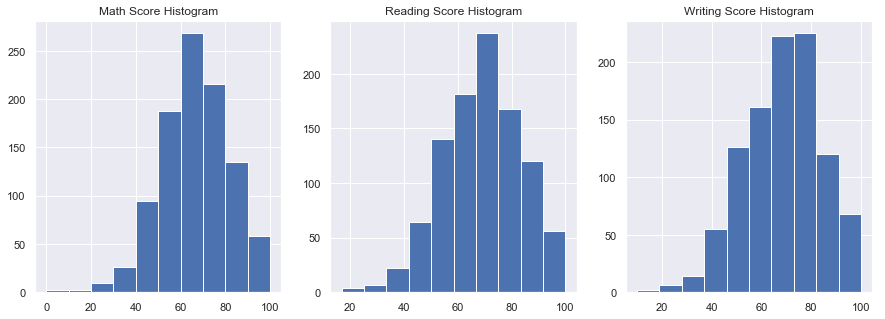

Math Score NormaltestResult(statistic=15.408960513931822, pvalue=0.00045080293869937836)
Reading Score NormaltestResult(statistic=11.11741279628622, pvalue=0.003853758403576582)
Writing Score NormaltestResult(statistic=13.606450837263859, pvalue=0.0011101885439899974)


In [34]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.hist(df_student["math score"])
plt.title("Math Score Histogram")

plt.subplot(1, 3, 2)
plt.hist(df_student["reading score"])
plt.title("Reading Score Histogram")

plt.subplot(1, 3, 3)
plt.hist(df_student["writing score"])
plt.title("Writing Score Histogram")
plt.show()

print("Math Score", normaltest(df_student["math score"]))
print("Reading Score", normaltest(df_student["reading score"]))
print("Writing Score", normaltest(df_student["writing score"]))

The very small p-values from the normaltest indicate that it is very unlikey that these data are normally distributed.

Math Score boxcox NormaltestResult(statistic=1.8323073377495822, pvalue=0.40005482895717037)
Reading Score boxcox NormaltestResult(statistic=5.282274611852865, pvalue=0.07128015609575467)
Writing Score boxcox NormaltestResult(statistic=6.267311355043339, pvalue=0.04355827085023795)


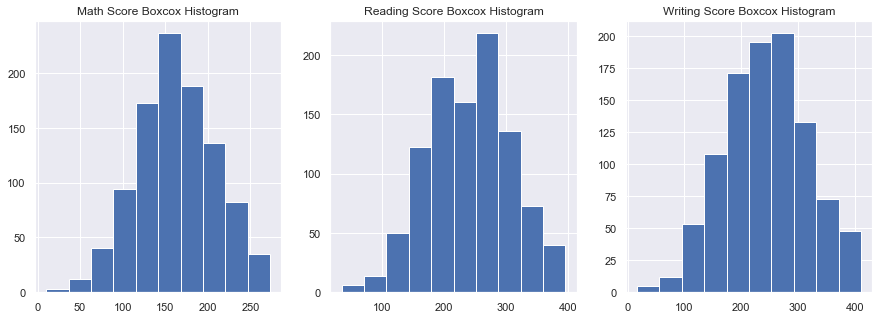

In [37]:
math_boxcox,_ = boxcox(df_student[df_student["math score"] > 0]["math score"])
reading_boxcox,_ = boxcox(df_student["reading score"])
writing_boxcox,_ = boxcox(df_student["writing score"])

print("Math Score boxcox", normaltest(math_boxcox))
print("Reading Score boxcox", normaltest(reading_boxcox))
print("Writing Score boxcox", normaltest(writing_boxcox))

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.hist(math_boxcox)
plt.title("Math Score Boxcox Histogram")

plt.subplot(1, 3, 2)
plt.hist(reading_boxcox)
plt.title("Reading Score Boxcox Histogram")

plt.subplot(1, 3, 3)
plt.hist(writing_boxcox)
plt.title("Writing Score Boxcox Histogram")

plt.show()

After applying the boxcox transformation, the data are closer to a normal distribution (although probably still not quite there, based on the p-values)

## 2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.

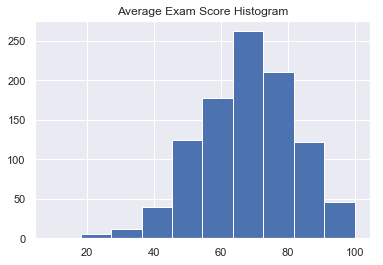

Average Exam Score NormaltestResult(statistic=15.186721327231322, pvalue=0.0005037851534494478)


In [40]:
average_exam_score = (df_student["math score"] +
              df_student["reading score"] + 
              df_student["writing score"])/3

plt.hist(average_exam_score)
plt.title("Average Exam Score Histogram")
plt.show()

print("Average Exam Score", normaltest(average_exam_score))

Based on the normaltest p-value, the new variable is not normally distributed.

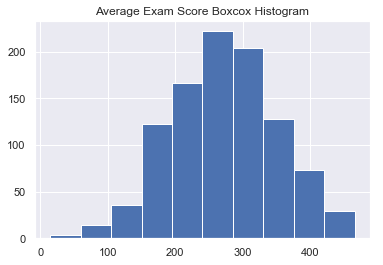

Average Exam Score Boxcox NormaltestResult(statistic=2.779857245981238, pvalue=0.2490930835165177)


In [41]:
average_exam_score_boxcox,_ = boxcox(average_exam_score)

plt.hist(average_exam_score_boxcox)
plt.title("Average Exam Score Boxcox Histogram")
plt.show()

print("Average Exam Score Boxcox", normaltest(average_exam_score_boxcox))

The boxcox transformed variable is normally distributed.

## 3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

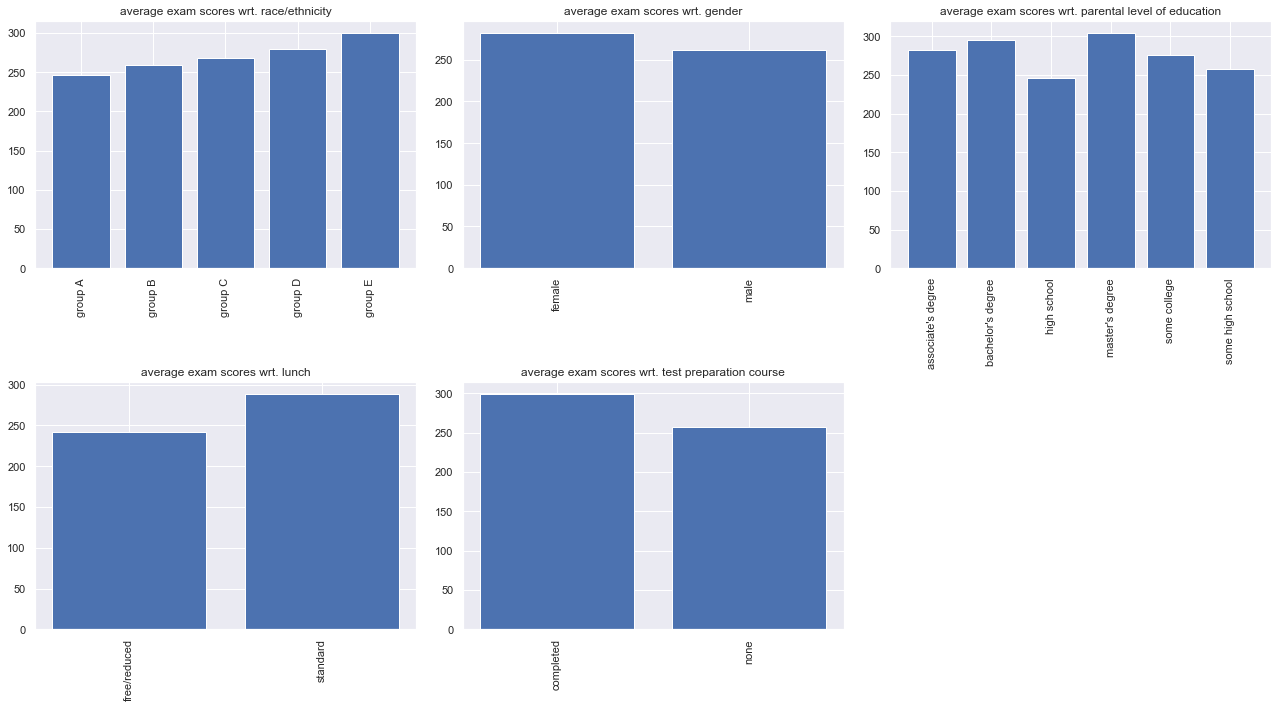

In [44]:
df_student["exam_score"] = average_exam_score_boxcox

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.bar(df_student.groupby("race/ethnicity")
        ["exam_score"].mean().index, df_student.groupby("race/ethnicity")["exam_score"].mean())

plt.title("average exam scores wrt. race/ethnicity")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 2)
plt.bar(df_student.groupby("gender")
        ["exam_score"].mean().index, df_student.groupby("gender")["exam_score"].mean())

plt.title("average exam scores wrt. gender")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 3)
plt.bar(df_student.groupby("parental level of education")
        ["exam_score"].mean().index, df_student.groupby("parental level of education")["exam_score"].mean())

plt.title("average exam scores wrt. parental level of education")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 4)
plt.bar(df_student.groupby("lunch")
        ["exam_score"].mean().index, df_student.groupby("lunch")["exam_score"].mean())

plt.title("average exam scores wrt. lunch")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 5)
plt.bar(df_student.groupby("test preparation course")
        ["exam_score"].mean().index, df_student.groupby("test preparation course")["exam_score"].mean())

plt.title("average exam scores wrt. test preparation course")
plt.xticks(rotation="vertical")

plt.tight_layout()
plt.show()

All five categorical variables appear related to the target variable, although there is probably a lurking variable affecting the lunch category. 